# SP+ End-to-end Evaluation: Annotation

## 0. Setting up your environment
0a.) Install spp client to your local device: pip install -i https://pip.s2.allenai.org/simple spp_client.      
0b.) Download json files from s3://ai2-s2-mmda/citation-link-evaluation-sample/ for Grobid data.

## 1. Get data from annotation store via spp_client

### 1a. Get and set sources
Retreive information about the sources for each annotation - mentions, bib-entries, bib-entry-parses, and pdf plumber

In [1]:
####################################################################
# ANNOTATOR TODO: change this to sha you're analyzing
####################################################################

#This sha will get overwritten when running autogenerater script
sha = 'd85b756b8e4d584a53483c6562eb968efdb1fc0c'


In [2]:
# SPP version for Eval Sample
spp_version = "0.0.81"

# Get annotation sources using annotation store attribute data for given spp_version and sha
import urllib.request, json 

spp_source = f"spp-{spp_version}"
with urllib.request.urlopen(f"http://annotations-api.dev.s2.allenai.org/pdf/{sha}/annotations?"
                            f"annotationSources=none&attributeSources={spp_source}") as url:
    data = json.load(url)
    
    if not data['attributesFromSource'].get(spp_source):
        print(f"No annotations available for sha {sha} with spp_source {spp_source}")
        print("data:")
        print(json.dumps(data, indent=2))
    else:
        spp_sources_for_version = data['attributesFromSource'][spp_source]
        print(f"Got SPP source info for sha {sha} with spp_source {spp_source}:")
        print(json.dumps(spp_sources_for_version, indent=2))



Got SPP source info for sha d85b756b8e4d584a53483c6562eb968efdb1fc0c with spp_source spp-0.0.81:
{
  "bib-entry": {
    "document-type": [
      "PlainText",
      "PDF"
    ],
    "bib-entry-detector-source": "bib-entry-detector-0.0.1|vila-0.0.2|pdfplumber-0.0.8",
    "bib-entry-predictor-source": "bib_entry_predictor-0.0.1|bib-entry-detector-0.0.1|pdfplumber-0.0.8"
  },
  "plain-text-doc-id": "d7e6b60249dc301db1ffb7588edb719b9d0785f0",
  "dictionary-word-predictor-source": "dwp-0.0.6|vila-0.0.2|pdfplumber-0.0.8",
  "pdf-plumber-source": "pdfplumber-0.0.8",
  "citation": {
    "document-type": [
      "PlainText",
      "PDF"
    ],
    "citation-link-source": "citation-links-0.0.1|bib-entry-detector-0.0.1|citation_mentions-0.0.1",
    "citation-mention-source": "citation_mentions-0.0.1|pdfplumber-0.0.8"
  },
  "layout-parser": "layout-parser-0.0.2|pdfplumber-0.0.8",
  "vila-source": "vila-0.0.2|layout-parser-0.0.2|pdfplumber-0.0.8"
}


### 1b. Retrieve Annotations
Using the sources obtained from the previous cell, we will now retreive the annotations for each source via spp_client.

In [3]:
# Get annotations and data as text using spp client
from spp_client.client import DocumentAnnotations, SppClient

client = SppClient.mk(env="dev")

doc_annos = [
    DocumentAnnotations(
        source = spp_sources_for_version["citation"]["citation-mention-source"],
        annotation_type="citation_mentions"
    ),
    
    DocumentAnnotations(
        source = spp_sources_for_version["bib-entry"]["bib-entry-detector-source"],
        annotation_type="bib_entries"
    ),
    
    DocumentAnnotations(
        source = spp_sources_for_version["bib-entry"]["bib-entry-predictor-source"],
        annotation_type= "bib_entry_titles"
    ),
    
    DocumentAnnotations(
        source = spp_sources_for_version["bib-entry"]["bib-entry-predictor-source"],
        annotation_type= "bib_entry_authors"
    ),  
]

mmda_doc, as_pdf_annos, as_text_annos = client.get_mmda_and_as_docs(
    sha,
    spp_sources_for_version["pdf-plumber-source"],
    doc_annos,
    include_images=True
)

#get doc_id to use for getting linking data
data1 = as_text_annos
doc_id = data1.doc_id

In [4]:
mmda_doc.fields

['tokens',
 'pages',
 'rows',
 'citation_mentions',
 'bib_entries',
 'bib_entry_titles',
 'bib_entry_authors']

## 2. Visalize Mentions (draw boxes)
Use draw_boxes to visualize each mention.

### 2a. Make boxgroups for mentions so that boxes can be drawn for them.

In [5]:
#imports
from collections import defaultdict
import layoutparser.elements as lpe
import layoutparser.visualization as lpv
from typing import List

#function to create box groups from mentions on the mmda doc
def make_boxgroups_mentions(mmda_doc):

    result_boxes_list = defaultdict(list)
    dictionary_of_boxes = defaultdict(list)
    
    for cite in mmda_doc.citation_mentions:
        for span in cite.spans:
            dictionary_of_boxes[span.box.page].append(span.box) 
    
    #mapping between pages and spans on page
    for page, list_of_boxes in dictionary_of_boxes.items():
        page_w, page_h = mmda_doc.images[page].size


        for box in list_of_boxes:
            if box.page == page:
                result_boxes_list[page].append(lpe.Rectangle(
                        box.l * page_w,
                        box.t * page_h,
                        (box.l + box.w) * page_w,
                        (box.t + box.h) * page_h
                    ))
            else:
                raise ValueError('Page number')
    return result_boxes_list

### 2b. Make boxes for Grobid annotation

In [6]:
import os
import requests
import json
import boto3

####################################################################
# ANNOTATOR TODO: Update with path to your grobid papers and uncomment below
# if the s3 code doesn't work.
# Annos are in s3://ai2-s2-mmda/citation-link-evaluation-sample-2/grobid_annotation
####################################################################
# with open(f'/Users/baileyk/Work/mmda/spp_grobid/{sha}.json') as f:
#     grobid_annotation = json.load(f)

# s3 code
s3_resource = boto3.resource('s3')
key = f"citation-link-evaluation-sample-2/grobid_annotation/{sha}.json"
obj = s3_resource.Object("ai2-s2-mmda", key)

try:
    grobid_annotation = json.loads(obj.get()["Body"].read().decode("utf-8"))
    print("grobid annos found.")
except:
    print(f"no grobid annotations found at s3://ai2-s2-mmda/{key}")
    grobid_annotation = dict()

grobid annos found.


In [7]:
def make_boxgroup_mentions_from_grobid(grobid_annotation):
    result_boxes_list = defaultdict(list)
    for mention in grobid_annotation["refMarkers"]:
        page = mention["p"]
        box = lpe.Rectangle(
            mention["x"], 
            mention["y"], 
            mention["x"] + mention["w"],
            mention["y"] + mention["h"]
        )
        result_boxes_list[page].append(box)
    return result_boxes_list

#egor version
def draw_boxgroups(image, rectangle_list, color_map=None, id_map=None):
    viz = []
    if color_map is None:
        color_map={'color_1': 'blue', 'color_2': 'green', 'color_3': 'yellow', 'color_4': 'pink'}

    for rectangle in rectangle_list:
        viz.append(lpe.TextBlock(rectangle,
                                 type=f'color_1'
                                )
                  )

    if image:
        return lpv.draw_box(image,
                            viz,
                            color_map=color_map,
                            show_element_id=False,
                            id_font_size=10)
    
    return None

## 3. Get references and s2 id's for each mention.

### 3a. Retreive citation mention numbers and which bib entries they are linked to.

In [8]:
# get annotation data from json file, plain-text
import urllib.request, json 
with urllib.request.urlopen(f"http://annotations-api.dev.s2.allenai.org/plain-text/{doc_id}/annotations?"
                            f"annotationSources=all&attributeSources=all") as url:
    data = json.load(url)

mention_detection_source = spp_sources_for_version["citation"]["citation-mention-source"]
bib_mention_linker_source = spp_sources_for_version["citation"]["citation-link-source"]

# ie: for citation_mention '0', the bib_entry_id it's linked to is '3'. 
citation_links = defaultdict(int)

for i in data['annotationsFromSource'][f'{mention_detection_source}']['citation_mentions']:
    #set key to citation mention
    citation_mention_id = i['attributesFromSource'][mention_detection_source]['id']
    
    #set value to bib entry id
    linked_bib_id = i['attributesFromSource'][bib_mention_linker_source]['bib_entry_id']
    
    #add to list of citation link data
    citation_links[citation_mention_id] = int(linked_bib_id)

### 3b. Use API call to find what s2 paper each bib entry is linked to.

In [9]:
def get_index_of_bib_entry_with_id(bib_entry_id):
    linked_bib_entry_index_list = [i for i, bib_entry in enumerate(mmda_doc.bib_entries) if bib_entry.id == bib_entry_id]
    assert len(linked_bib_entry_index_list) == 1, f"there should be exactly one bib_entry with the id {bib_entry_id}."
    return linked_bib_entry_index_list[0]

def extract_first_group_symbols(span_groups):
    try: 
        first_one = span_groups[0] 
        text = first_one.symbols[0]
    except IndexError: # case where was no annotation detected so span_groups was empty list
            text = "" # it can be empty or say "no text detected" or something
    return text


def get_bib_entry_title(citation_mention_id):
    linked_bib_id = citation_links[citation_mention_id]
    # print("linked_bib_id: ", linked_bib_id)
    # Accessing the linked bib_entry this way is error-prone because MMDA annotations can't be assumed to be sorted by SpanGroup IDs
    # bib_title_span_groups = mmda_doc.bib_entries[linked_bib_id].bib_entry_titles 
    # We have to find the correct bib_entry this way:
    linked_bib_index = get_index_of_bib_entry_with_id(linked_bib_id)
    
    bib_title_span_groups = mmda_doc.bib_entries[linked_bib_index].bib_entry_titles 
    text_symbols = extract_first_group_symbols(bib_title_span_groups)

    return text_symbols

def get_full_bib_entry_text(citation_mention_id):
    linked_bib_id = citation_links[citation_mention_id]
    linked_bib_index = get_index_of_bib_entry_with_id(linked_bib_id)

    bib_span_groups = [mmda_doc.bib_entries[linked_bib_index]]
    text_symbols = extract_first_group_symbols(bib_span_groups)

    return text_symbols

In [10]:
#make api call to get linked papers
def bibLinkingApiPost(title, end_point='http://pipeline-api.prod.s2.allenai.org/citation/match'):
    payload = json.dumps([{'title': title}])
    headers = {
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", end_point, headers=headers, data=payload).json()
    return response


#get s2_ids linked to each mention
s2_ids = []
for citation_mention in mmda_doc.citation_mentions:
    title = get_bib_entry_title(citation_mention.id)
    s2_ids.append(str((bibLinkingApiPost(title))).replace('[', '').replace(']', ''))

print(s2_ids)

['235446522', '235446522', '206591190', '6070091', '54558282', '211506988', '174801560', '18021059', '1843173', '9579103', '54475483', '53875671', '2429016', '19052864', '-1', '214713500', '3865699', '3477836', '11003934', '214713500', '214713500', '20282961', '20282961', '235446522', '208139191', '235446522', '235446522', '20635214', '20635214', '235446522', '-1', '214713500', '3865699', '20282961', '214713500', '20282961', '20282961', '214713500', '20282961', '20282961', '214713500', '235446522', '10328909', '-1', '235446522', '206591190', '6070091', '235446522', '206591190', '20635214', '6070091', '235446522', '235446522', '10328909', '14113767', '-1', '218470050', '235446522', '561197', '206591190', '6070091', '2429016', '19052864', '3865699', '214713500', '20635214', '235446522', '20635214', '235446522', '235446522', '235446522', '235446522', '-1', '221319569', '235446522', '235446522', '235446522', '235446522', '-1', '6070091', '206591190', '3865699']


## 4. Annotation Info!

In [11]:
####################################################################
# ANNOTATOR TODO: Record page # from output in annotation spreadsheet
####################################################################

# get random page number to review and annotate
import random

pages_w_mentions = [citation_mention.pages[0].id + 1 for citation_mention in mmda_doc.citation_mentions for citation_mention in mmda_doc.citation_mentions]

annot_page = random.choice(pages_w_mentions)
print("page to annotate:", annot_page)

page to annotate: 2


In [12]:
#gives table of mentions and their corresponding bib_entry ids, s2 linked papers 
import pandas as pd
from IPython.display import HTML

ref_info = {
    # "Mention ID": [citation_mention.id for citation_mention in mmda_doc.citation_mentions],
    "Page": [citation_mention.pages[0].id + 1 for citation_mention in mmda_doc.citation_mentions],
    "Mention text": [citation_mention.symbols for citation_mention in mmda_doc.citation_mentions],
    # TODO: use DWP "words" text instead of doc.symbols (ex: the title "Reaction-Diﬀusion processes and meta-population mod-\nels in Heterogeneous Networks" gives no match, but manually changing "mod-\nels" to "models" results in an S2 id match)
    "Linked Bib Entry Title": [get_bib_entry_title(citation_mention.id) for citation_mention in mmda_doc.citation_mentions],    
    "Linked Bib Entry Extracted Text": [get_full_bib_entry_text(citation_mention.id) for citation_mention in mmda_doc.citation_mentions],    
    # "Linked Bib id": [citation_links[citation_mention.id] for citation_mention in mmda_doc.citation_mentions],
    "S2 id:": [ids if ids != str(-1) else " " for ids in s2_ids],
    "S2 url": [f"http://api.semanticscholar.org/corpusid:{ids}" if ids != str(-1) else " " for ids in s2_ids]
    }

df = pd.DataFrame.from_dict(ref_info, orient='index')
df = df.transpose()

# selecting rows based on random page selected to annotate
# you can comment the line below out to see all mentions across all pages
df = df[df['Page'] == annot_page]


#make s2 links clickable
HTML(df.to_html(render_links=True, escape=False))

,Page,Mention text,Linked Bib Entry Title,Linked Bib Entry Extracted Text,S2 id:,S2 url
1,2,[25],X-MAN: Ex-\nplaining multiple sources of anomalies in video,"[25] S. Szymanowicz, J. Charles, and R. Cipolla. X-MAN: Ex-\nplaining multiple sources of anomalies in video. In CVPR\nWorkshops , 2021.",235446522,http://api.semanticscholar.org/corpusid:235446522
2,2,[16],Anomaly detection in crowded scenes,"[16] V. Mahadevan, W. Li, V. Bhalodia, and N. Vasconcelos.\nAnomaly detection in crowded scenes. In CVPR , 2010.",206591190,http://api.semanticscholar.org/corpusid:206591190
3,2,[14],Abnormal event detection at 150 fps\nin matlab,"[14] C. Lu, J. Shi, and J. Jia. Abnormal event detection at 150 fps\nin matlab. In ICCV , 2013.",6070091,http://api.semanticscholar.org/corpusid:6070091
4,2,[4],Deep\nanomaly detection with outlier exposure,"[4] D. Hendrycks, M. Mazeika, and T. Dietterich.\nDeep\nanomaly detection with outlier exposure. arXiv preprint\narXiv:1812.04606 , 2018.",54558282,http://api.semanticscholar.org/corpusid:54558282
5,2,[6],Generalized odin: Detecting out-of-distribution image with-\nout learning from out-of-distribution data,"[6] Yen-Chang Hsu, Yilin Shen, Hongxia Jin, and Zsolt Kira.\nGeneralized odin: Detecting out-of-distribution image with-\nout learning from out-of-distribution data. In CVPR , 2020.",211506988,http://api.semanticscholar.org/corpusid:211506988
6,2,[21],Likelihood ratios for out-of-distribution de-\ntection,"[21] Jie Ren, Peter J Liu, Emily Fertig, Jasper Snoek, Ryan\nPoplin, Mark A DePristo, Joshua V Dillon, and Balaji Lak-\nshminarayanan. Likelihood ratios for out-of-distribution de-\ntection. arXiv preprint arXiv:1906.02845 , 2019.",174801560,http://api.semanticscholar.org/corpusid:174801560
7,2,[17],Analyzing tracklets for the detection of abnormal\ncrowd behavior,"[17] H. Mousavi, S. Mohammadi, A. Perina, R. Chellali, and V.\nMurino. Analyzing tracklets for the detection of abnormal\ncrowd behavior. In WACV , 2015.",18021059,http://api.semanticscholar.org/corpusid:18021059
8,2,[24],Real-\ntime anomaly detection and localization in crowded scenes,"[24] M. Sabokrou, M. Fathy, M. Hoseini, and R. Klette. Real-\ntime anomaly detection and localization in crowded scenes.\nIn CVPR , 2015.",1843173,http://api.semanticscholar.org/corpusid:1843173
9,2,[28],Abnormal event detec-\ntion using spatio-temporal feature and nonnegative locality-\nconstrained linear coding,"[28] Y. Zhao, L. Zhou, K. Fu, and J. Yang. Abnormal event detec-\ntion using spatio-temporal feature and nonnegative locality-\nconstrained linear coding. In ICIP , 2016.",9579103,http://api.semanticscholar.org/corpusid:9579103
10,2,[7],Object-centric auto-encoders and dummy anomalies for ab-\nnormal event detection in video,"[7] R. T. Ionescu, F. S. Khan, M. Georgescu, and L. Shao.\nObject-centric auto-encoders and dummy anomalies for ab-\nnormal event detection in video. In CVPR , 2019.",54475483,http://api.semanticscholar.org/corpusid:54475483


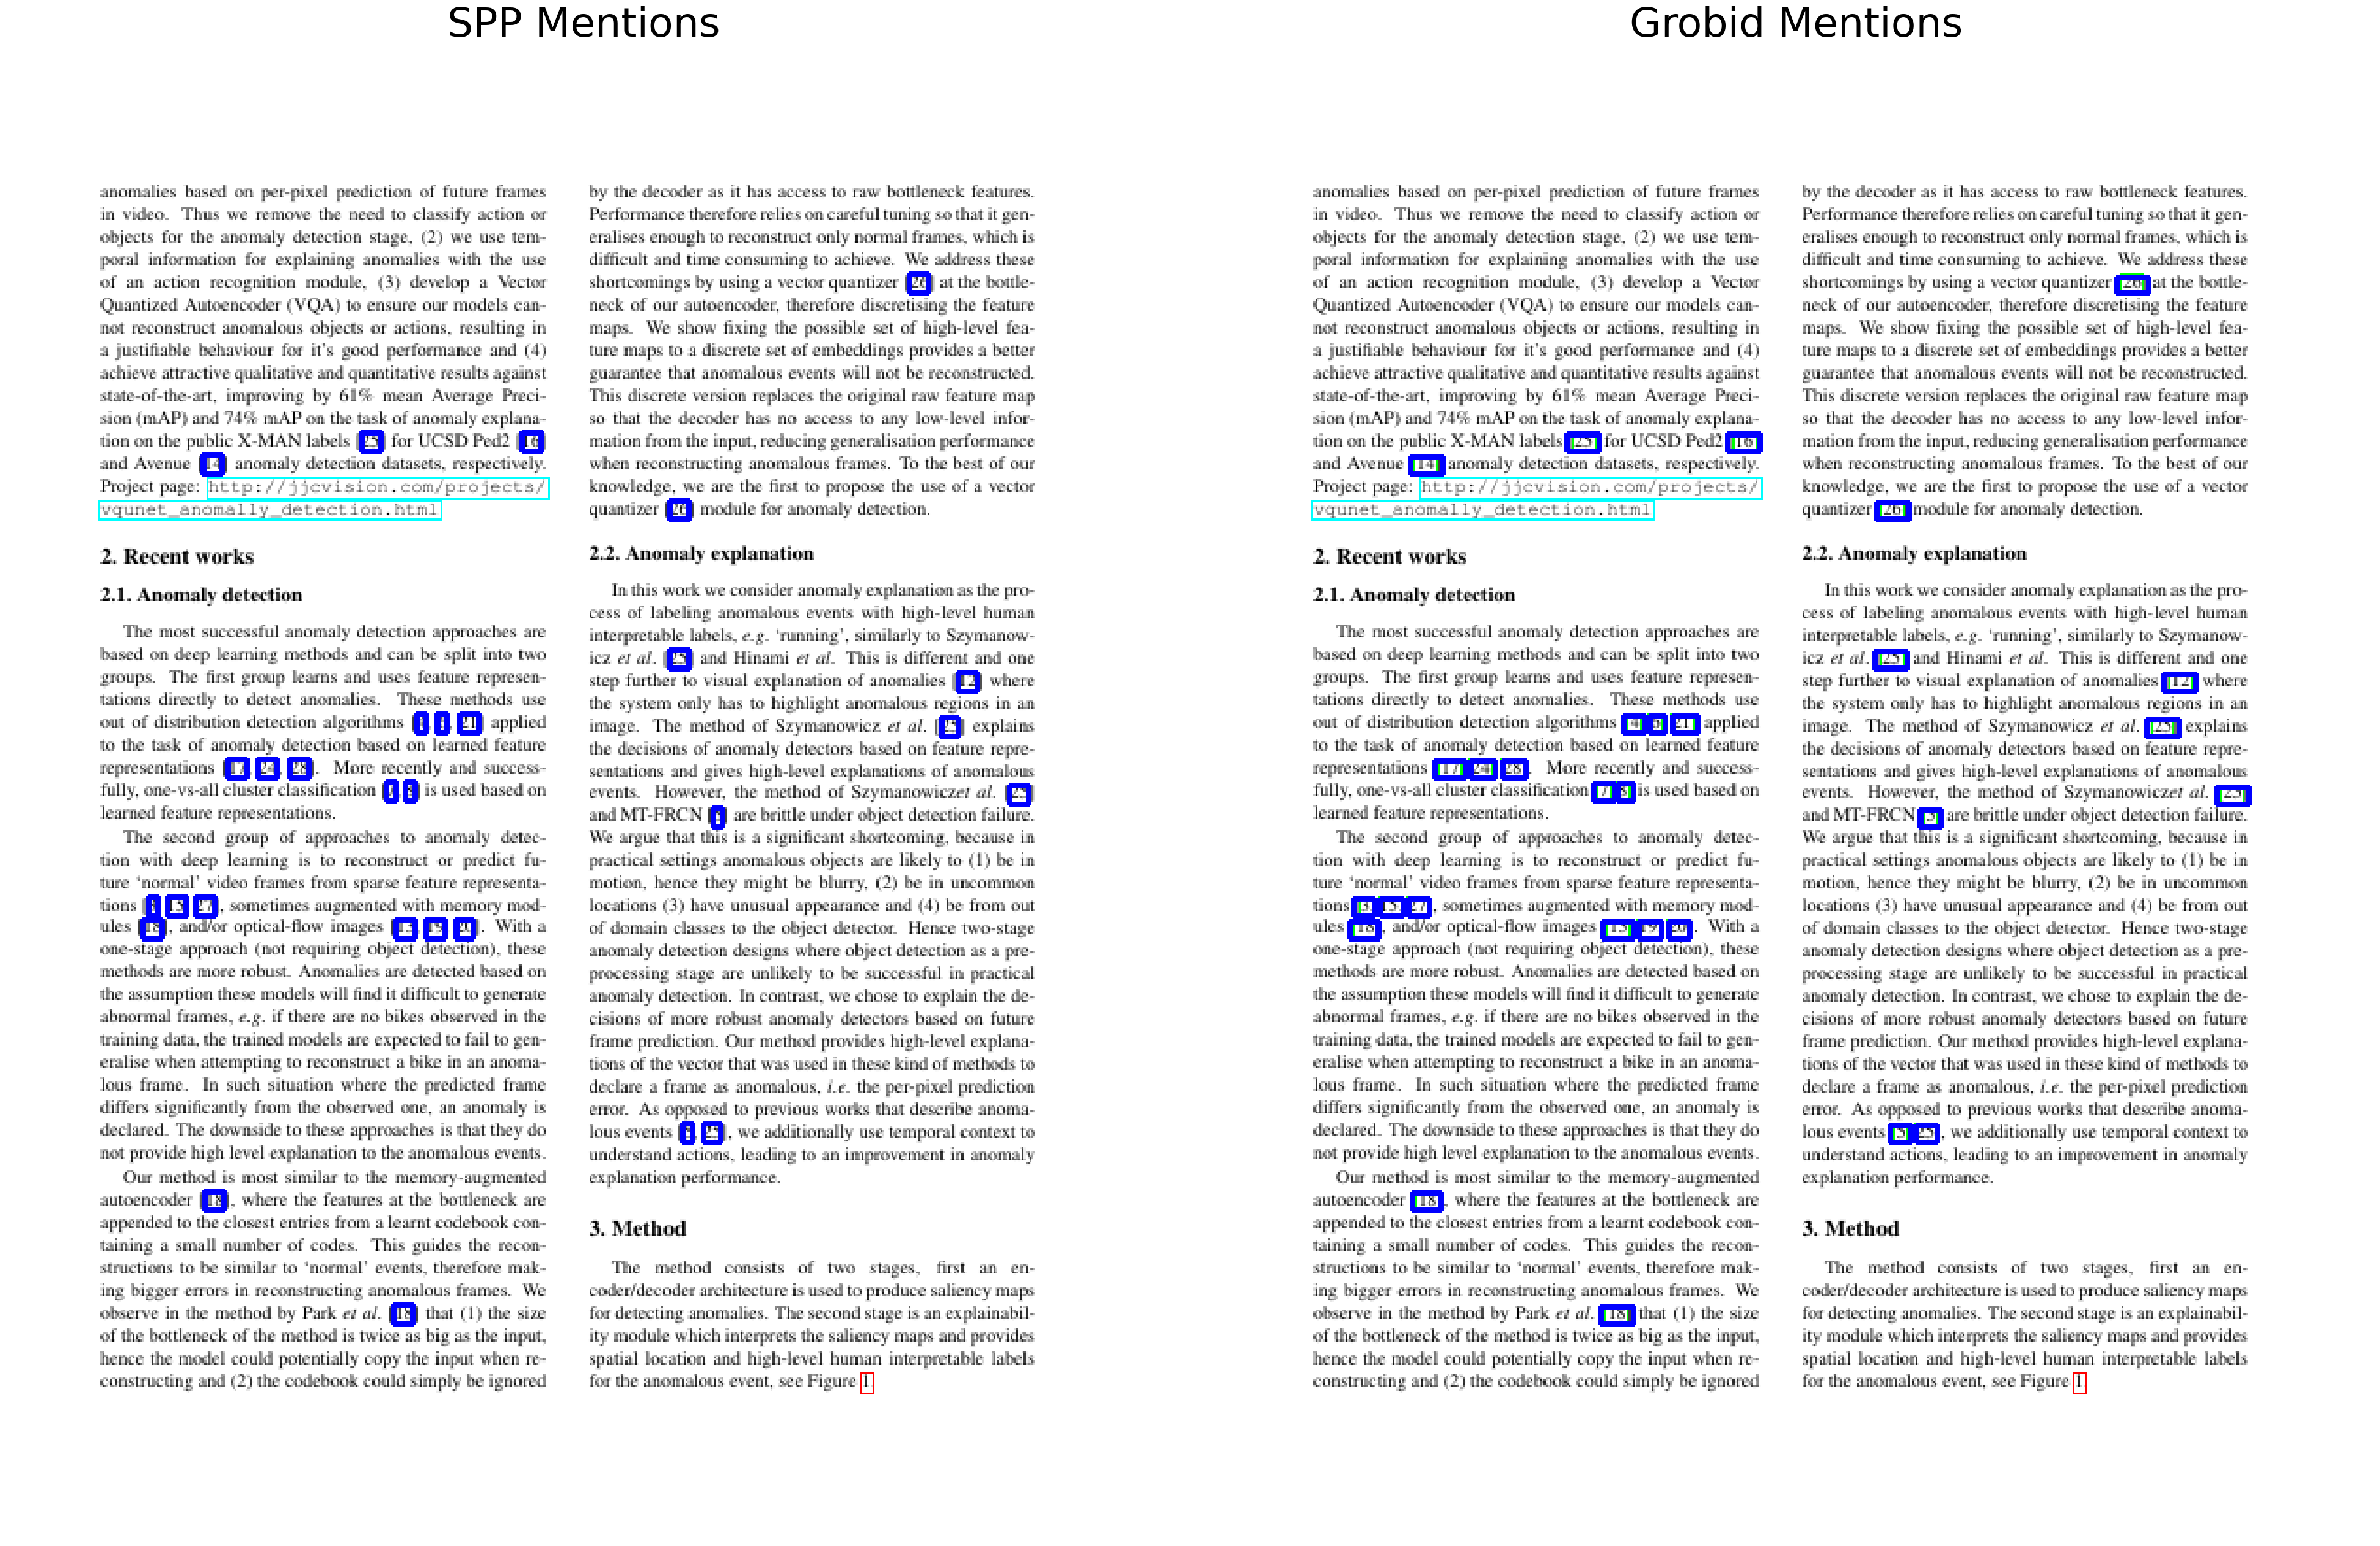

In [13]:
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure


rows = 1
columns = 2
fontsize = 48

#spp
#make boxes and save as image
dic_boxgroups = make_boxgroups_mentions(mmda_doc)
image1 = draw_boxgroups(mmda_doc.images[annot_page-1], list(dic_boxgroups[annot_page-1]))

#plot
fig = plt.figure(figsize=(50, 50))
fig.add_subplot(rows, columns, 1)
plt.axis('off')
plt.title("SPP Mentions",fontdict={'fontsize': fontsize})
plt.imshow(image1)


#grobid
#make boxes and save as image
boxgroups = make_boxgroup_mentions_from_grobid(grobid_annotation)
image2 = draw_boxgroups(mmda_doc.images[annot_page-1], list(boxgroups[annot_page]))

#plot side by side
fig.add_subplot(rows, columns, 2)
plt.axis('off')
plt.title("Grobid Mentions",fontdict={'fontsize': fontsize})
plt.imshow(image2)
plt.subplots_adjust(bottom=0.15, wspace=0.05)

## ANNOTATOR TODO: 
Record each mention on this page (regardless of if it got recognized by SPP or not) as 1 row in the spreadsheet.